In [1]:
from audiot import *

# Interpolation between digital chords

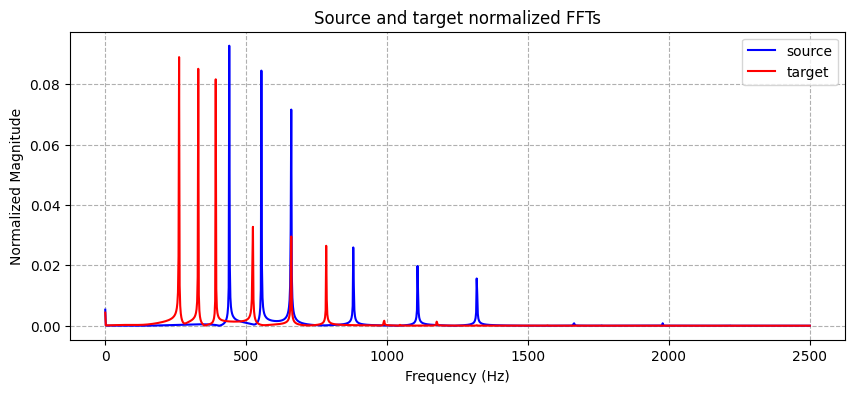

In [2]:
sr = 44100
duration = 0.5
smooth_len = 100
max_frequency = 2500

source_path = SOUNDS / 'digital/A_digital.wav'
target_path = SOUNDS / 'digital/C_digital.wav'

source_signal = load_signal(source_path, sr=sr, duration=duration, smooth_len=smooth_len)
target_signal = load_signal(target_path, sr=sr, duration=duration, smooth_len=smooth_len)

source_fft, support = fft_normalized(source_signal, sr=sr, return_support=True, max_frequency=max_frequency)
target_fft = fft_normalized(target_signal, sr=sr, max_frequency=max_frequency)

plot_signals(support, signals=[source_fft, target_fft], labels=['source', 'target'], title='Source and target normalized FFTs', colors=['b', 'r'])

/tmp/ipykernel_16708/3021721583.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return (f_s - f_t)**2 / f_s
/tmp/ipykernel_16708/3021721583.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  return (f_s - f_t)**2 / f_s
/tmp/ipykernel_16708/3021721583.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return (f_s - f_t)**2 / (f_s * f_t)
/tmp/ipykernel_16708/3021721583.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return (f_s - f_t)**2 / (f_s * f_t)


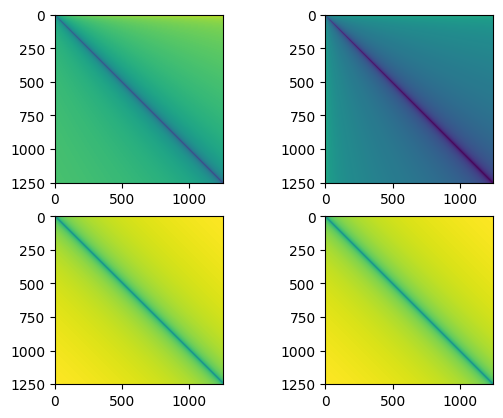

In [3]:
# Optimal transport

from math import log

alpha = 0.5

def dist1(f_s, f_t):
    return (f_s - f_t)**2 / f_s

def dist2(f_s, f_t):
    return (f_s - f_t)**2 / (f_s * f_t)

def dist3(f_s, f_t):
    return (f_s - f_t)**2

def dist4(f_s, f_t):
    if f_t == 0 or f_s == 0:
        return np.inf
    return f_s / f_t - log(f_s / f_t) - 1

def cost_matrix_amp(support, source, target, dist=euclidean, amp_dist=None, meth=None):

    n_samples = len(support)

    M = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(n_samples):
            if amp_dist is not None:
                if meth == 'add':
                    A = amp_dist(source[i], target[j])
                    M[i, j] = dist(support[i], support[j]) + A
                if meth == 'mult':
                    A = amp_dist(source[i], target[j])
                    M[i, j] = dist(support[i], support[j]) * A
            else:
                M[i, j] = dist(support[i], support[j])

    return M

def normalized_cost_matrix(support, source, target, dist, amp_dist=None, amp_meth=None, meth=None):
        
    M = cost_matrix_amp(support, source, target, dist=dist, amp_dist=amp_dist, meth=amp_meth)

    max_value = np.nanmax(M[np.isfinite(M)])

    M[np.isinf(M)] = max_value
    M[np.isnan(M)] = max_value

    if meth == 'sum':
        for i in range(M.shape[0]):
            M[i] = M[i] / np.sum(M)
    if meth == 'rowsum':
        for i in range(M.shape[0]):
            M[i] = M[i] / np.sum(M[i])
            
    if meth == 'max':
        for i in range(M.shape[0]):
            M[i] = M[i] / np.max(M)

    if meth == 'rowmax':
        for i in range(M.shape[0]):
            M[i] = M[i] / np.max(M[i])

    if meth == None:
        return M

    return M

M1 = normalized_cost_matrix(support, source_fft, target_fft, dist=dist1)
M2 = normalized_cost_matrix(support, source_fft, target_fft,dist=dist2)
M3 = normalized_cost_matrix(support, source_fft, target_fft,dist=dist3)
M4 = normalized_cost_matrix(support, source_fft, target_fft,dist=dist3)

vmin = min(np.log(M1 + 1e-5).min(), np.log(M2 + 1e-5).min(), np.log(M3 + 1e-5).min(), np.log(M4 + 1e-5).min())
vmax = max(np.log(M1 + 1e-5).max(), np.log(M2 + 1e-5).max(), np.log(M3 + 1e-5).max(), np.log(M4 + 1e-5).max())
plt.subplot(2,2,1)
plt.imshow(np.log(M1 + 1e-5), vmin=vmin, vmax=vmax)
plt.subplot(2,2,2)
plt.imshow(np.log(M2 + 1e-5), vmin=vmin, vmax=vmax)
plt.subplot(2,2,3)
plt.imshow(np.log(M3 + 1e-5), vmin=vmin, vmax=vmax)
plt.subplot(2,2,4)
plt.imshow(np.log(M4 + 1e-5), vmin=vmin, vmax=vmax)

In [4]:
interpolation_1, plan_1 = emd(support, source_fft, target_fft, M1, alpha)
interpolation_2, plan_2 = emd(support, source_fft, target_fft, M2, alpha)
interpolation_3, plan_3 = emd(support, source_fft, target_fft, M3, alpha)
interpolation_4, plan_4 = emd(support, source_fft, target_fft, M4, alpha)


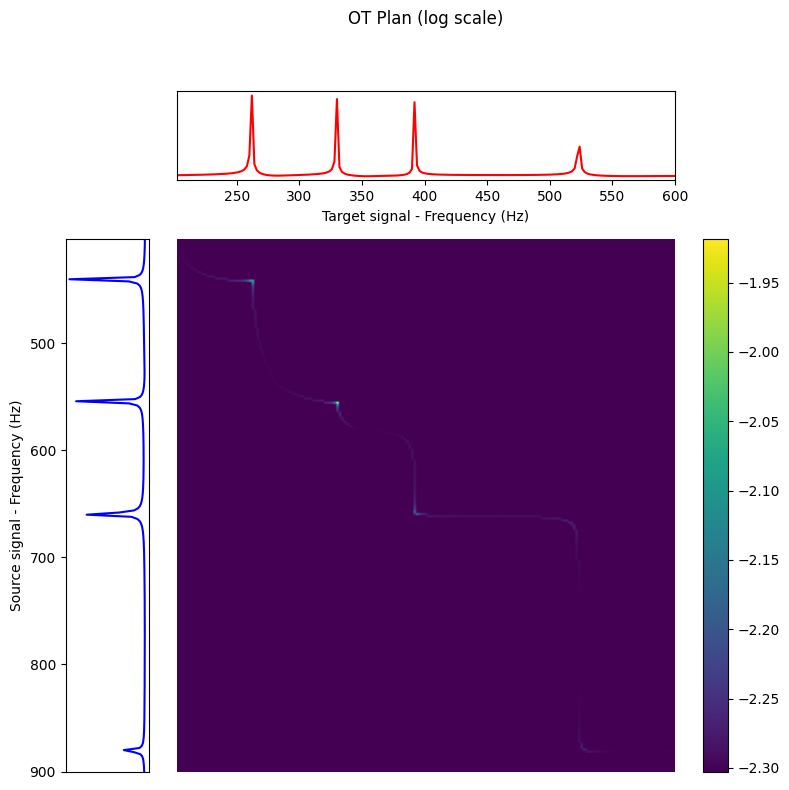

In [5]:
source_freq_start=400
source_freq_end=900
target_freq_start=200
target_freq_end=600
plot_plan_spectra(support, 
                  source_fft, 
                  target_fft, 
                  plan_1, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-1)


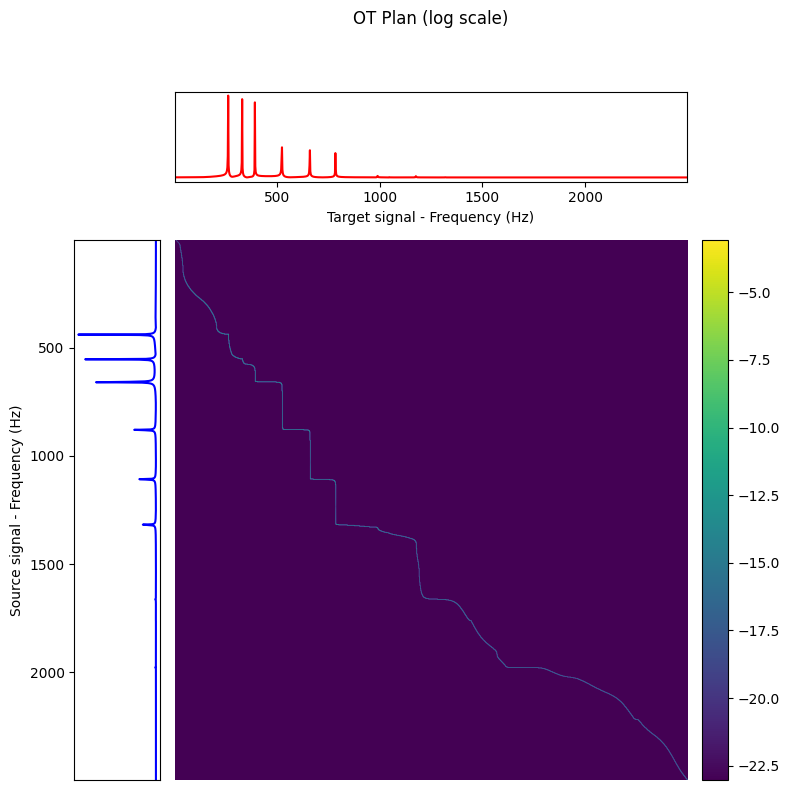

In [6]:
source_freq_start=0
source_freq_end=-1
target_freq_start=0
target_freq_end=-1
plot_plan_spectra(support, 
                  source_fft, 
                  target_fft, 
                  plan_2, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-10)


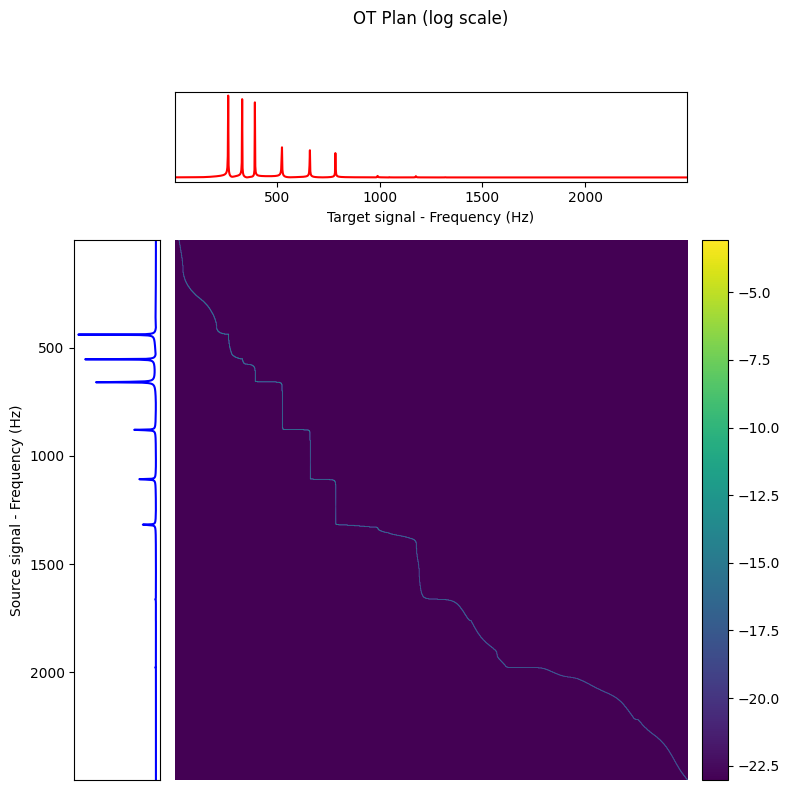

In [7]:
source_freq_start=0
source_freq_end=-1
target_freq_start=0
target_freq_end=-1
plot_plan_spectra(support, 
                  source_fft, 
                  target_fft, 
                  plan_3, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-10)


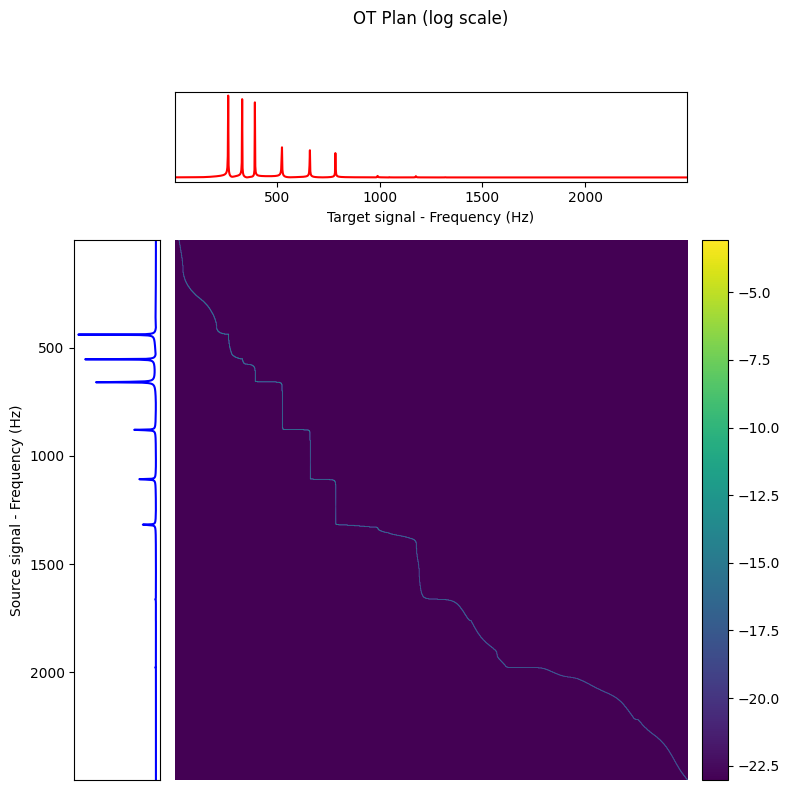

In [8]:
source_freq_start=0
source_freq_end=-1
target_freq_start=0
target_freq_end=-1
plot_plan_spectra(support, 
                  source_fft, 
                  target_fft, 
                  plan_4, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-10)


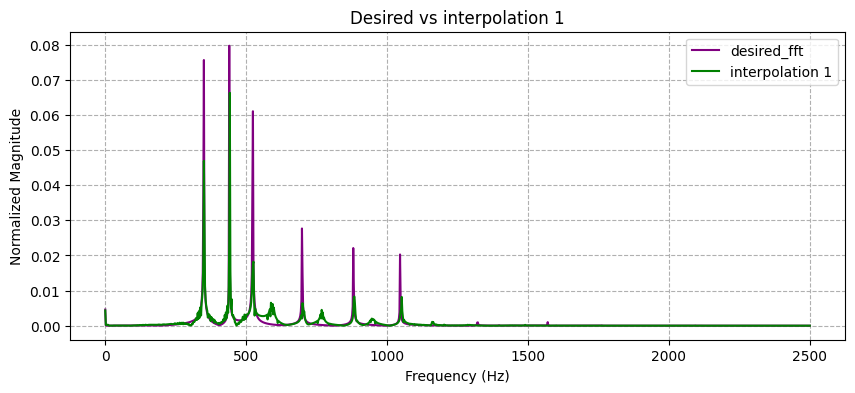

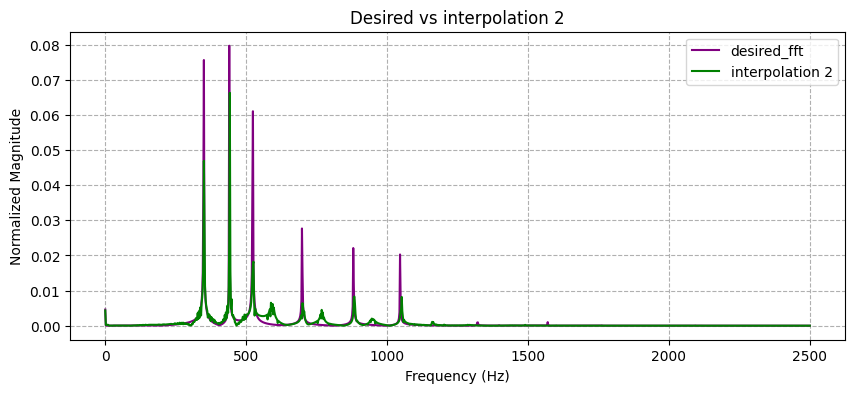

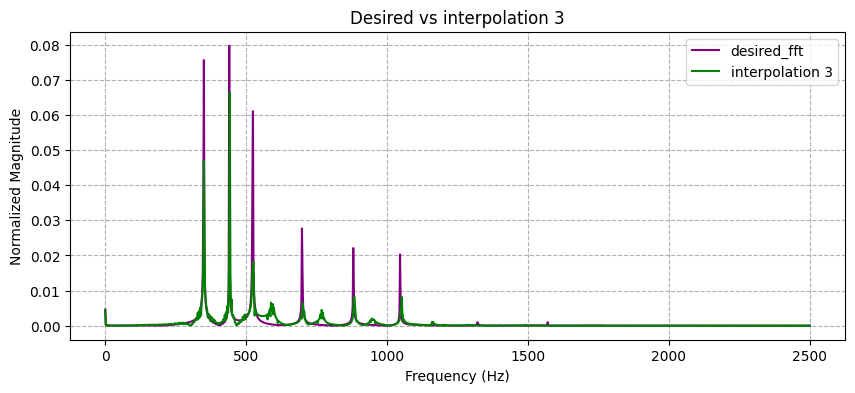

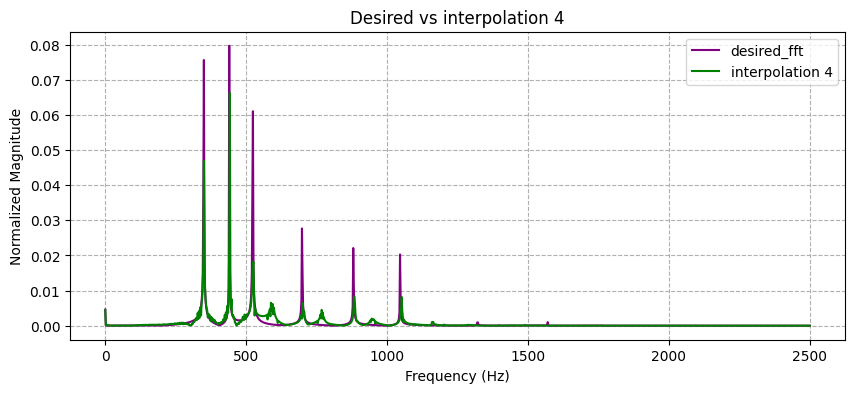

In [9]:
desired_interpolation = SOUNDS / 'digital/F_digital.wav'

desired_signal = load_signal(desired_interpolation, sr=sr, duration=duration, smooth_len=smooth_len)

desired_fft = fft_normalized(desired_signal, sr=sr, return_support=False, max_frequency=max_frequency)

plot_signals(support, signals=[desired_fft, interpolation_1], labels=['desired_fft', 'interpolation 1'], title='Desired vs interpolation 1', colors=['purple', 'g'])
plot_signals(support, signals=[desired_fft, interpolation_2], labels=['desired_fft', 'interpolation 2'], title='Desired vs interpolation 2', colors=['purple', 'g'])
plot_signals(support, signals=[desired_fft, interpolation_3], labels=['desired_fft', 'interpolation 3'], title='Desired vs interpolation 3', colors=['purple', 'g'])
plot_signals(support, signals=[desired_fft, interpolation_4], labels=['desired_fft', 'interpolation 4'], title='Desired vs interpolation 4', colors=['purple', 'g'])


In [10]:
def complex_interpolation(interpolation, source, target, alpha):
    phase = (1 - alpha) * np.angle(source) + alpha * np.angle(target)

    return interpolation * np.exp(1j * phase)

complex_interpolation_1 = np.fft.irfft(complex_interpolation(interpolation_1, source_fft, target_fft, alpha), n=source_signal.shape[0])
complex_interpolation_2 = np.fft.irfft(complex_interpolation(interpolation_2, source_fft, target_fft, alpha), n=source_signal.shape[0])
complex_interpolation_3 = np.fft.irfft(complex_interpolation(interpolation_3, source_fft, target_fft, alpha), n=source_signal.shape[0])
complex_interpolation_4 = np.fft.irfft(complex_interpolation(interpolation_4, source_fft, target_fft, alpha), n=source_signal.shape[0])

signals = [source_signal, target_signal, complex_interpolation_1, complex_interpolation_2, complex_interpolation_3, complex_interpolation_4]
titles = ['source', 'target', 'interpolation 1' , 'interpolation 2', 'interpolation 3' , 'interpolation 4']
audio_widgets = [audio_widget(signal, title) for signal, title in zip(signals, titles)]

grid = widgets.VBox(audio_widgets)
grid

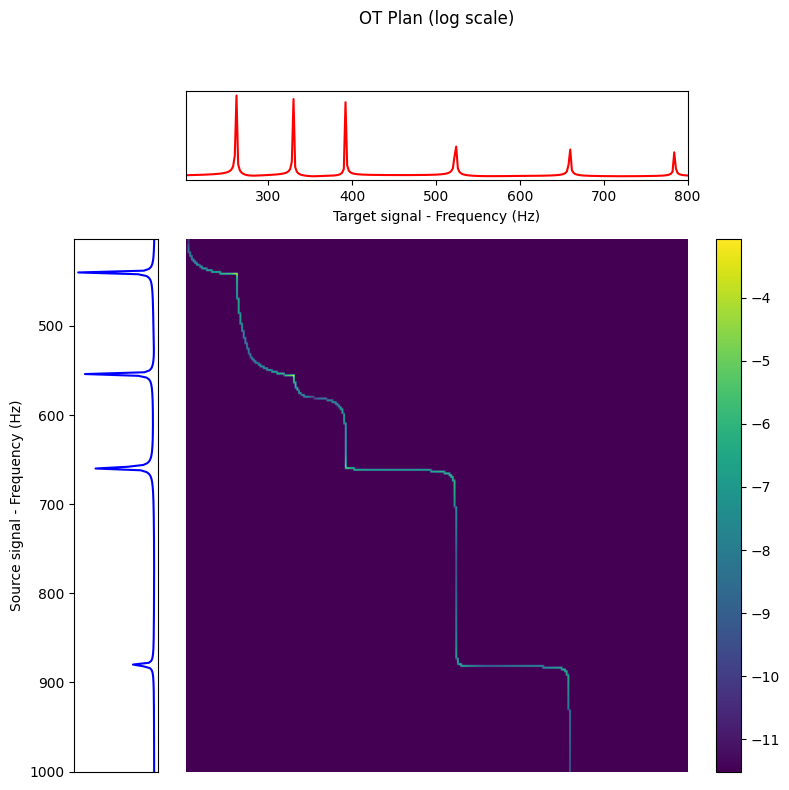

In [11]:
source_freq_start=400
source_freq_end=1000
target_freq_start=200
target_freq_end=800
plot_plan_spectra(support, 
                  source_fft, 
                  target_fft, 
                  plan_1, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-5)


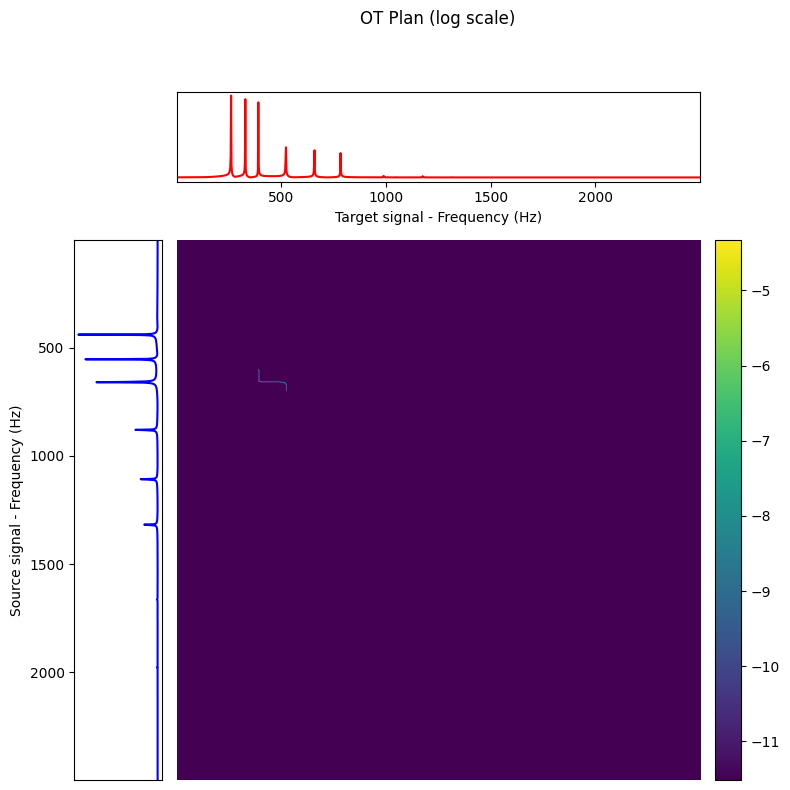

In [12]:
source_freq_start = frequency_to_index(support, 600)
source_freq_end = frequency_to_index(support, 700)
target_freq_start = frequency_to_index(support, 0)
target_freq_end = frequency_to_index(support, -1)
cut_plan = np.zeros_like(plan_1)
cut_plan[source_freq_start:source_freq_end, target_freq_start:target_freq_end] = plan_1[source_freq_start:source_freq_end, target_freq_start:target_freq_end]

source_freq_start=0
source_freq_end=-1
target_freq_start=0
target_freq_end=-1
plot_plan_spectra(support, 
                  source_fft, 
                  target_fft, 
                  cut_plan, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-5)


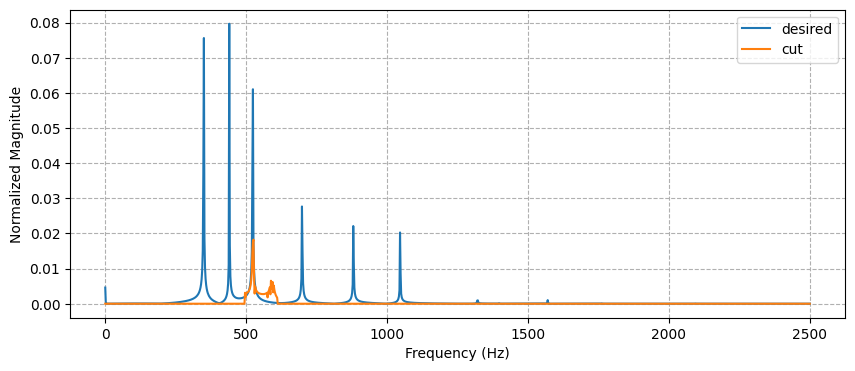

In [13]:
cut_plan = csr_matrix(cut_plan)
cut_interpolation = np.zeros(len(support))
row, col = cut_plan.nonzero()

for f_s, f_t in zip(row, col):
    index = interpolate_frequency(f_s, f_t, alpha=alpha)
    cut_interpolation[index] += cut_plan[f_s, f_t]

cut_plan = np.array(cut_plan.todense())

plot_signals(support, [desired_fft, cut_interpolation], ['desired', 'cut'])